<h1>Прогнозирование временного ряда</h1>

Рассмотрим данные о продажах некой группы товаров за 2017 год.
<br>
<b><i>Задача:</i></b> каким либо образом построить прогноз на последний месяц, имея данные за 11 предыдущих. 

<h2>Используемые модули</h2>

In [1]:
import sqlite3                   # Работа с базой данных sqlite3
import pandas as pd              # Работа с датасетами

import matplotlib.pyplot as plt  # Построение графиков
import numpy as np               # Тут лежит ряд нужных констант, например NaN

<h2>Подключение базы данных</h2>

In [2]:
connection = sqlite3.connect('../data/db.sqlite')
print("База данных подключена успешно!")

База данных подключена успешно!


In [3]:
cursor = connection.cursor()

# Общее количество товаров
sql_query = '''
SELECT COUNT(DISTINCT GoodCode)
FROM (SELECT *
      FROM Sales_2017
      UNION ALL
      SELECT *
      FROM Sales_2018
)
'''
for row in cursor.execute(sql_query):
    print("Всего типов товаров: %d" % row[0])

Всего типов товаров: 1536


In [4]:
# Число товаров, коды которых присутствуют в обоих таблицах
sql_query = '''
SELECT COUNT(DISTINCT GoodCode)
FROM (SELECT GoodCode
      FROM Sales_2017
      INTERSECT
      SELECT GoodCode
      FROM Sales_2018
)
'''
for row in cursor.execute(sql_query):
    print("Товаров в обоих таблицах: %d" % row[0])

Товаров в обоих таблицах: 914


<h2>Загрузка датасета</h2>

Мы считаем, что все представленные товары принадлежат к некоторой одной категории. Будем предсказывать общее количество проданных товаров этой категории за сутки. Поэтому возьмём за датасет посуточную общую продажу всех товаров.

In [5]:
sql_query = '''
SELECT DocDate       AS Date
     , SUM(Quantity) AS Quantity
FROM (SELECT *
      FROM Sales_2017
      UNION ALL
      SELECT *
      FROM Sales_2018
)
WHERE GoodCode IN (SELECT GoodCode
                   FROM Sales_2017
                   INTERSECT
                   SELECT GoodCode
                   FROM Sales_2018
)
GROUP BY DocDate
'''
dataset = pd.read_sql(sql_query, connection, index_col='Date', parse_dates=['Date'])
dataset = dataset.sort_index()

print('Данные представлены за %d дня.' % dataset.size)
print('Первые пять кортежей:')
dataset[:5]

Данные представлены за 377 дня.
Первые пять кортежей:


,Quantity
Date,
2017-01-02,74073.504
2017-01-03,94021.017
2017-01-04,73727.667
2017-01-05,38391.285
2017-01-06,90506.913


Получили, что данные за 2018 год какие-то бессмысленные, поэтому будем работать только с 2017 годом.

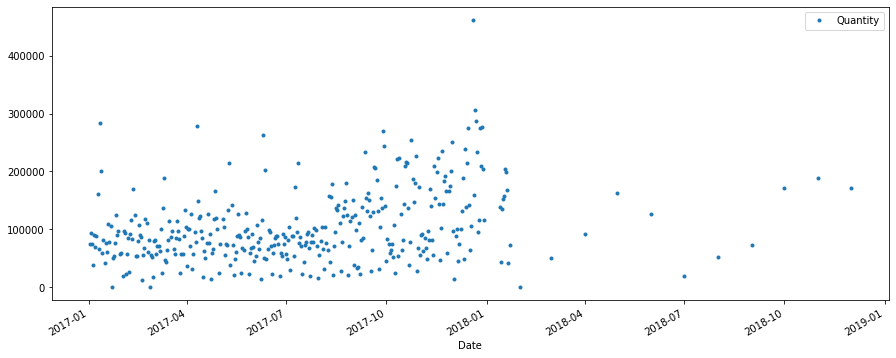

In [6]:
dataset.plot(figsize=(15, 6), style='.')

plt.show()

<h2>Подготовка данных</h2>

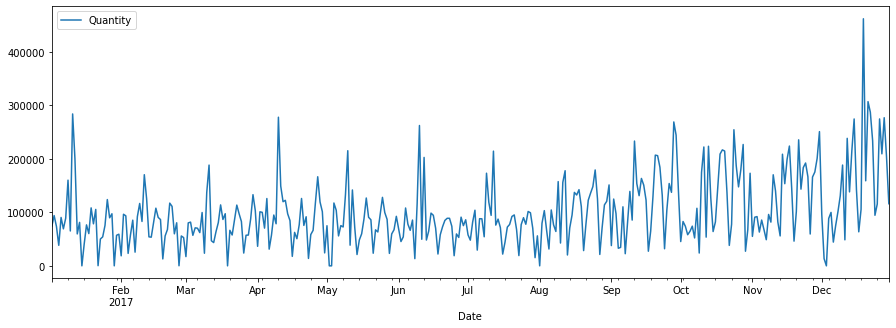

In [239]:
# Возьмем данные за 2017 год
fit_df = dataset[dataset.index < '2017-12-31']

# Дополним отсутствующие данные предыдущим нулями,
# т.к. в эти дни не совершалось покупок (возможно,
# это праздничные дни)
fit_df = fit_df.resample('D').sum();

fit_df.plot(figsize=(15, 5))
plt.show()

In [240]:
test_df = fit_df[fit_df.index >= '2017-12-01']
fit_df  = fit_df[fit_df.index <  '2017-12-01']

<h2>Небольшой анализ</h2>

Видно, что в поведении графика наблюдается месячная периодичность и восходящий тренд. Причем она становится отчетливой под конец рассматриваемого периода.

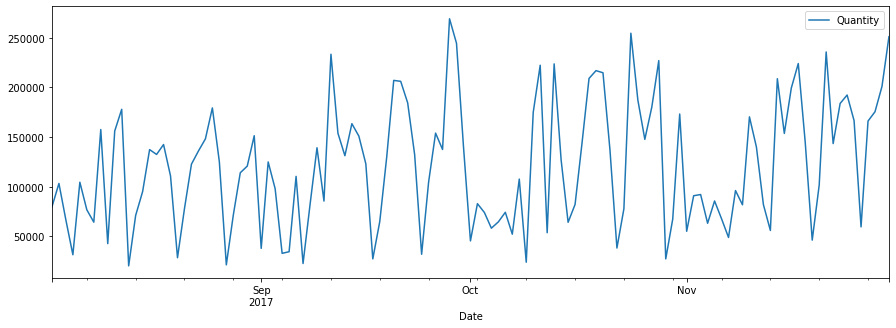

In [241]:
fit_df[fit_df.index > '2017-08-01'].plot(figsize=(15, 5))
plt.show()

Методом подбора параметров, оптимальным периодом можно считать 28 дней

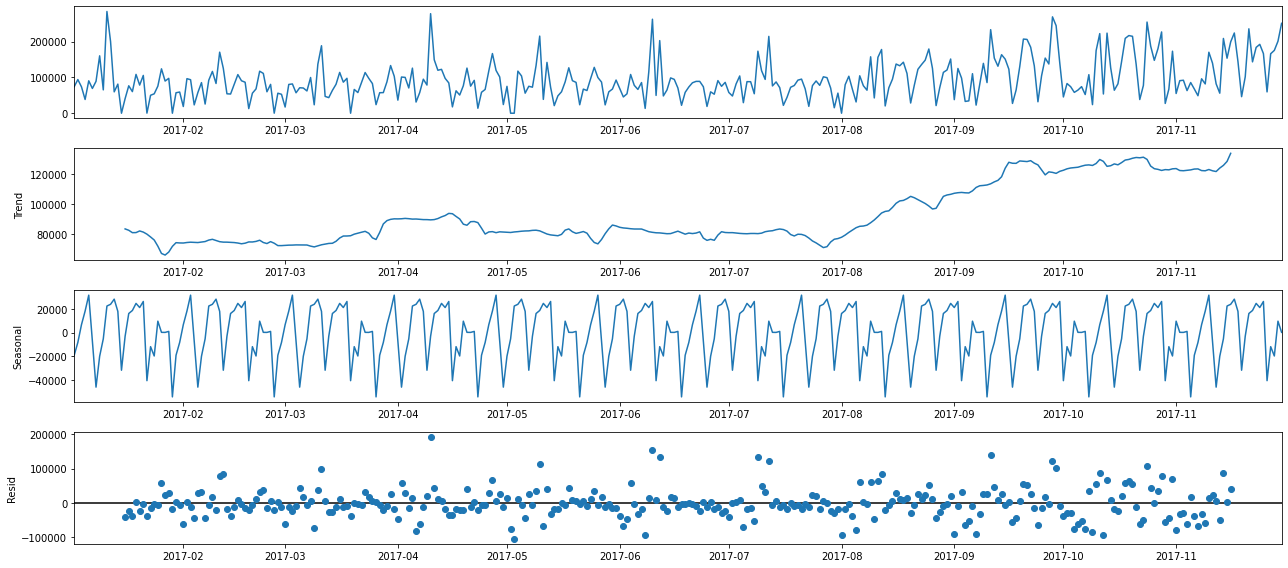

In [207]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(fit_df, model='additive', period=28)
fig = decomposition.plot()
plt.show()

In [208]:
import itertools

season_length = 28

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], season_length) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(fit_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}28 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 28)28 - AIC:8653.844899300464
ARIMA(0, 0, 0)x(0, 0, 1, 28)28 - AIC:7797.09668918394
ARIMA(0, 0, 0)x(0, 1, 0, 28)28 - AIC:7529.668495535402
ARIMA(0, 0, 0)x(0, 1, 1, 28)28 - AIC:6804.190715553179
ARIMA(0, 0, 0)x(1, 0, 0, 28)28 - AIC:7544.332487139672
ARIMA(0, 0, 0)x(1, 0, 1, 28)28 - AIC:7484.26353905197
ARIMA(0, 0, 0)x(1, 1, 0, 28)28 - AIC:6837.8646392644705
ARIMA(0, 0, 0)x(1, 1, 1, 28)28 - AIC:6802.763995625089
ARIMA(0, 0, 1)x(0, 0, 0, 28)28 - AIC:8465.959241016277
ARIMA(0, 0, 1)x(0, 0, 1, 28)28 - AIC:7697.9060108970025
ARIMA(0, 0, 1)x(0, 1, 0, 28)28 - AIC:7499.436217808056
ARIMA(0, 0, 1)x(0, 1, 1, 28)28 - AIC:6769.4921588961715
ARIMA(0, 0, 1)x(1, 0, 0, 28)28 - AIC:7711.4005781605065
ARIMA(0, 0, 1)x(1, 0, 1, 28)28 - AIC:7652.827589164248
ARIMA(0, 0, 1)x(1, 1, 0, 28)28 - AIC:6831.861637618618
ARIMA(0, 0, 1)x(1, 1, 1, 28)28 - AIC:6769.013336516772
ARIMA(0, 1, 0)x(0, 0, 0, 28)28 - AIC:8269.904349787179
ARIMA(0, 1, 0)x(0, 0, 1, 28)28 - AIC:7543.981837210726
ARIMA(0,

In [209]:
mod = sm.tsa.statespace.SARIMAX(fit_df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 28),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1706      0.099      1.717      0.086      -0.024       0.365
ma.L1         -0.9205      0.040    -22.992      0.000      -0.999      -0.842
ma.S.L28      -0.7946      0.068    -11.688      0.000      -0.928      -0.661
sigma2       4.21e+09   4.64e-12   9.08e+20      0.000    4.21e+09    4.21e+09


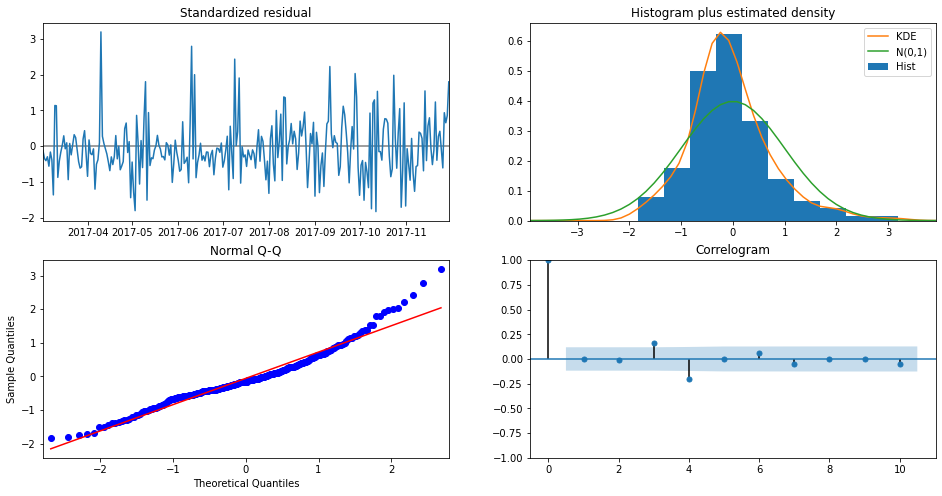

In [210]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

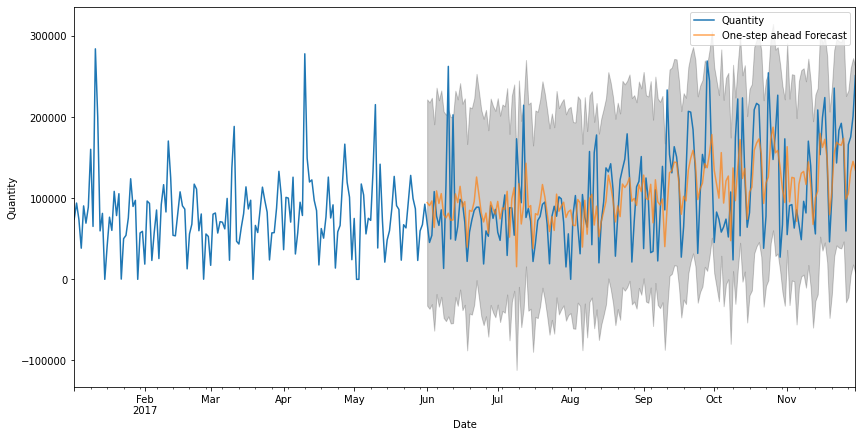

In [211]:
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = fit_df['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()

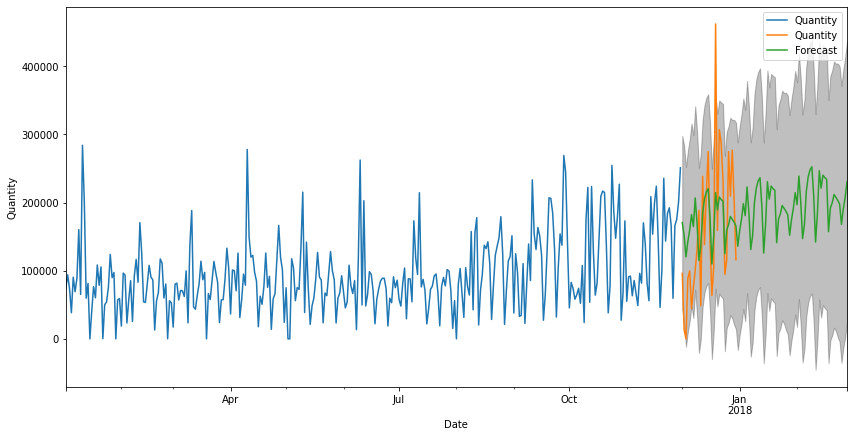

In [213]:
pred_uc = results.get_forecast(steps=90)
pred_ci = pred_uc.conf_int()
ax = fit_df.plot(label='observed', figsize=(14, 7))
test_df[test_df.index < '2018-05-01'].plot(ax=ax, label = '2018')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()

In [227]:
err = 0.0;
for i in range(test_df.size):
    err += abs(pred_uc.predicted_mean[i] - test_df['Quantity'][i])
err /= test_df.size

print('Средняя ошибка: %.2f' % err)

Средняя ошибка: 72340.11


<h2>Линейная регрессия</h2>

Будем использовать данные за предыдущие 28 дней и день недели, чтобы рассчитать значение на следующий день при помощи линейной регрессии.

In [228]:
# Возьмем данные за 2017 год
fit_df = dataset[dataset.index < '2017-12-31']

# Дополним отсутствующие данные предыдущим нулями,
# т.к. в эти дни не совершалось покупок (возможно,
# это праздничные дни)
fit_df = fit_df.resample('D').sum();

In [229]:
X_train = np.zeros((fit_df.size - 2*28, 28 + 7))

for i in range(X_train.shape[0]):
    for j in range(28):
        X_train[i][j] = fit_df['Quantity'][i + 28 - j - 1]
    X_train[i][28 + fit_df.index.dayofweek[i + 28]] = 1


Y_train = np.zeros((fit_df.size - 2*28, 1))

for i in range(Y_train.shape[0]):
    Y_train[i][0] = fit_df['Quantity'][i + 28]
    
X_test = np.zeros((28, 28 + 7))
for i in range(X_test.shape[0]):
    for j in range(28):
        X_test[i][j] = fit_df['Quantity'][fit_df.size - 28 + i - j - 1]
    X_test[i][28 + fit_df.index.dayofweek[fit_df.size - 28 + i]] = 1

Y_test = np.zeros((28, 1))
for i in range(Y_test.shape[0]):
    Y_test[i][0] = fit_df['Quantity'][fit_df.size - 28 + i]

In [232]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=0.001)
reg.fit(X_train, Y_train)



Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

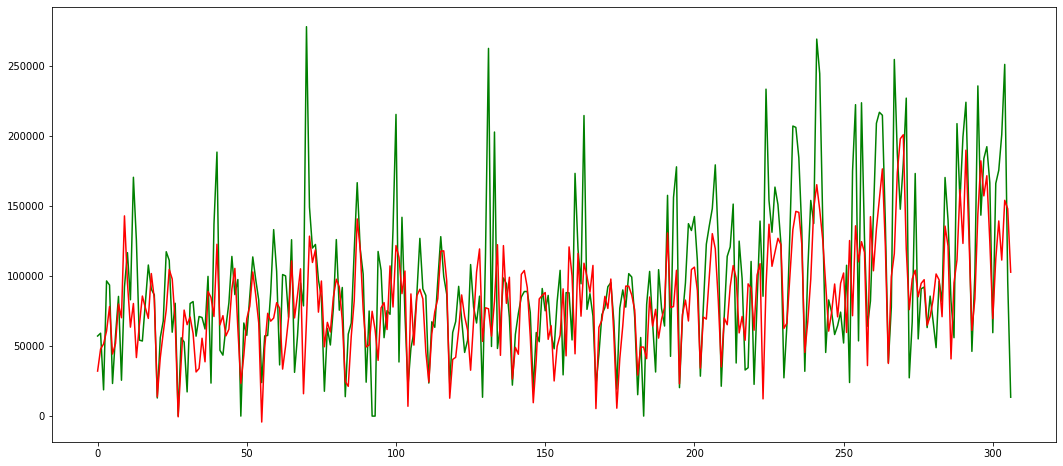

In [234]:
plt.plot(Y_train, 'g')
plt.plot(X_train.dot(reg.coef_.transpose()), color='r')

plt.show()

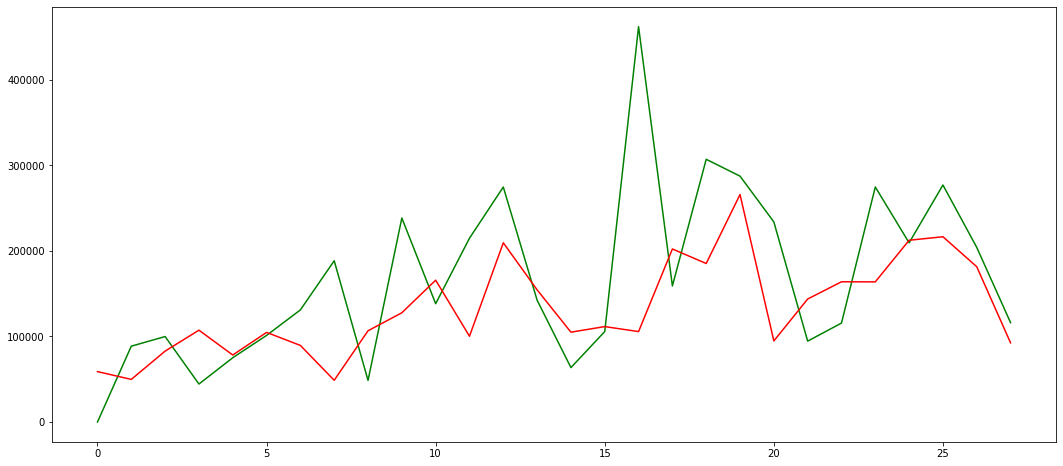

In [235]:
plt.plot(Y_test, 'g')
plt.plot(X_test.dot(reg.coef_.transpose()), 'r')

plt.show()

In [237]:
err = 0.0;
Y_pred = X_test.dot(reg.coef_.transpose())
for i in range(Y_test.shape[0]):
    err += abs(Y_test[i][0] - Y_pred[i][0])
err /= Y_test.shape[0]

print('Средняя ошибка: %.2f' % err)

Средняя ошибка: 64334.37
